In [1]:
#DQN FUNCTION
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

class PolicyNetwork(nn.Module):
    def __init__( self, lr, state_dim, num_layers, hidden_dim, num_actions):
        #self, state_dim, action_dim, *, num_layers=3, hidden_dim=256
        super(PolicyNetwork, self).__init__() #super constructor
        self.state_dim=state_dim
        self.lr=lr
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        
        self.layerss = nn.ModuleList().append(nn.Linear(*state_dim, hidden_dim))
        #self.linears.extend([nn.Linear(hidden_dim, hidden_dim) 
        for i in range(1, self.num_layers-1):
            self.layerss.append(nn.Linear(hidden_dim, hidden_dim))
        self.layerss.append(nn.Linear(hidden_dim, num_actions))        
        """
        self.fc1_dimensions=fc1_dimensions  #lunar lander env has 8 element single space vector observation
        self.fc2_dimensions=fc2_dimensions
        self.num_actions=num_actions
        self.fc1=nn.Linear(*self.input_dimensions, self.fc1_dimensions)
        self.fc2=nn.Linear(self.fc1_dimensions, self.fc2_dimensions)
        self.fc3=nn.Linear(self.fc2_dimensions, self.num_actions)
        self.optimizer=optim.Adam(self.parameters(),lr=lr)
        """
        self.optimizer=optim.Adam(self.parameters(),lr=lr)
        
        #self.device=T.device(CPU:0)
        #self.to(self.device)
        
    def forward(self, observation):
        """
        state=T.Tensor(observation)#.to(self.device)#convert numpy observation to tensor
        x=F.relu(self.fc1(state))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
            
        return x
        """
        state1=torch.Tensor(observation)#.to(self.device)
        x= nn.functional.relu(self.layerss[0](state1))
        for i in range(1, self.num_layers-1):
            x= nn.functional.relu(self.layerss[i](x))
        x= self.layerss[i+1](x)
        return x


In [2]:
class Agent(object):
    def __init__(self, lr, state_dim, gamma, num_layers, hidden_dim, num_actions):
        self.gamma=gamma
        self.action_memory=[]
        self.reward_memory=[]
        self.lr=lr
        self.state_dim=state_dim
        self.num_layers=num_layers
        self.hidden_dim=hidden_dim
        self.num_actions=num_actions
        self.policy = PolicyNetwork( self.lr, self.state_dim, self.num_layers, self.hidden_dim, self.num_actions)
        #self, lr, state_dim, *, num_layers=3, hidden_dim=256, num_actions
    
    def choose_action(self,observation):
        probabilities=F.softmax(self.policy.forward(observation))
        action_probabilities=T.distributions.Categorical(probabilities)
        action=action_probabilities.sample()
        log_probs=action_probabilities.log_prob(action)
        self.action_memory.append(log_probs)
        
        return action.item()
    
    #def store_rewards(self, reward):
    #    self.reward_memory.append(reward)
        
    def learn(self):
        self.policy.optimizer.zero_grad()
        G=np.zeros_like(self.reward_memory, dtype=np.float64)
        for t in range(len(self.reward_memory)):
            G_sum=0
            discount=1
            for k in range(t, len(self.reward_memory)):
                G_sum += self.reward_memory[k]*discount
                discount *= self.gamma
            G[t]=G_sum# at end of step store reward in G array
        
        mean=np.mean(G)
        
        if np.std(G)>0:
            std=np.std(G) 
        else:
            std=1
            
        G=T.tensor((G-mean)/std, dtype=T.float) #std could be zero so above line
        
        #G=T.tensor(G,dtype=T.float)#.to(self.policy.device)
        
        loss=0 #loss calculation
        for g, logprob in zip(G,self.action_memory):   #log probability=action_memory
            loss+= -g*logprob
            
        loss.backward()
        self.policy.optimizer.step()
        
        self.action_memory=[]
        self.reward_memory=[]
        

In [3]:
import numpy as np
import gym
from gym import wrappers#save playing video footage
import torch
from torch.distributions import constraints
from torch.distributions.exp_family import ExponentialFamily
from torch.distributions.utils import _standard_normal, broadcast_all

if __name__=='__main__':
    #env=gym.make('BipedalWalker-v2')
    env=gym.make('CartPole-v1')
    agent=Agent(lr=0.001, state_dim=[4], gamma=0.99, num_layers=3, hidden_dim=256,num_actions=2)
    score_history=[]
    score=0
    n_episodes=2500
        
    #segment generation at beginning/video
    #env=wrappers.Monitor(env,'tmp/lunar-lander',video_callable=lambda episode id: True, force=False)
    for i in range(n_episodes):
        print('episode: ',i, 'score %.3f' % score)
        done=False
        score = 0
        observation = env.reset()
        while not done:
            action=agent.choose_action(observation)
            observation_new,reward,done,info=env.step(action)
#           agent.store_rewards(reward)
            agent.reward_memory.append(reward)
            observation=observation_new
            score += reward
        score_history.append(score)
        agent.learn()
    filename='CartPole-v1.png'
    #plotLearningNoEpsilons(score_history, filename=filename,windoe=25)

episode:  0 score 0.000


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


episode:  1 score 65.000
episode:  2 score 26.000
episode:  3 score 48.000
episode:  4 score 20.000
episode:  5 score 18.000
episode:  6 score 11.000
episode:  7 score 29.000
episode:  8 score 27.000
episode:  9 score 16.000
episode:  10 score 38.000
episode:  11 score 18.000
episode:  12 score 27.000
episode:  13 score 39.000
episode:  14 score 31.000
episode:  15 score 68.000
episode:  16 score 44.000
episode:  17 score 27.000
episode:  18 score 66.000
episode:  19 score 79.000
episode:  20 score 34.000
episode:  21 score 72.000
episode:  22 score 53.000
episode:  23 score 18.000
episode:  24 score 68.000
episode:  25 score 34.000
episode:  26 score 36.000
episode:  27 score 61.000
episode:  28 score 32.000
episode:  29 score 193.000
episode:  30 score 50.000
episode:  31 score 26.000
episode:  32 score 39.000
episode:  33 score 17.000
episode:  34 score 21.000
episode:  35 score 63.000
episode:  36 score 44.000
episode:  37 score 84.000
episode:  38 score 107.000
episode:  39 score 

episode:  303 score 255.000
episode:  304 score 298.000
episode:  305 score 475.000
episode:  306 score 374.000
episode:  307 score 242.000
episode:  308 score 352.000
episode:  309 score 307.000
episode:  310 score 423.000
episode:  311 score 495.000
episode:  312 score 348.000
episode:  313 score 194.000
episode:  314 score 232.000
episode:  315 score 500.000
episode:  316 score 369.000
episode:  317 score 461.000
episode:  318 score 359.000
episode:  319 score 190.000
episode:  320 score 363.000
episode:  321 score 268.000
episode:  322 score 272.000
episode:  323 score 381.000
episode:  324 score 376.000
episode:  325 score 407.000
episode:  326 score 174.000
episode:  327 score 172.000
episode:  328 score 229.000
episode:  329 score 173.000
episode:  330 score 127.000
episode:  331 score 179.000
episode:  332 score 118.000
episode:  333 score 189.000
episode:  334 score 500.000
episode:  335 score 500.000
episode:  336 score 500.000
episode:  337 score 500.000
episode:  338 score 

episode:  599 score 500.000
episode:  600 score 500.000
episode:  601 score 500.000
episode:  602 score 500.000
episode:  603 score 500.000
episode:  604 score 500.000
episode:  605 score 500.000
episode:  606 score 500.000
episode:  607 score 500.000
episode:  608 score 500.000
episode:  609 score 500.000
episode:  610 score 500.000
episode:  611 score 500.000
episode:  612 score 500.000
episode:  613 score 500.000
episode:  614 score 500.000
episode:  615 score 500.000
episode:  616 score 500.000
episode:  617 score 500.000
episode:  618 score 500.000
episode:  619 score 500.000
episode:  620 score 500.000
episode:  621 score 500.000
episode:  622 score 500.000
episode:  623 score 500.000
episode:  624 score 500.000
episode:  625 score 500.000
episode:  626 score 500.000
episode:  627 score 500.000
episode:  628 score 500.000
episode:  629 score 500.000
episode:  630 score 500.000
episode:  631 score 500.000
episode:  632 score 500.000
episode:  633 score 500.000
episode:  634 score 

episode:  893 score 500.000
episode:  894 score 500.000
episode:  895 score 500.000
episode:  896 score 500.000
episode:  897 score 500.000
episode:  898 score 500.000
episode:  899 score 500.000
episode:  900 score 500.000
episode:  901 score 500.000
episode:  902 score 500.000
episode:  903 score 500.000
episode:  904 score 500.000
episode:  905 score 500.000
episode:  906 score 500.000
episode:  907 score 500.000
episode:  908 score 500.000
episode:  909 score 500.000
episode:  910 score 500.000
episode:  911 score 500.000
episode:  912 score 500.000
episode:  913 score 500.000
episode:  914 score 500.000
episode:  915 score 500.000
episode:  916 score 500.000
episode:  917 score 500.000
episode:  918 score 500.000
episode:  919 score 500.000
episode:  920 score 500.000
episode:  921 score 500.000
episode:  922 score 500.000
episode:  923 score 500.000
episode:  924 score 500.000
episode:  925 score 500.000
episode:  926 score 500.000
episode:  927 score 500.000
episode:  928 score 

episode:  1180 score 500.000
episode:  1181 score 500.000
episode:  1182 score 500.000
episode:  1183 score 500.000
episode:  1184 score 500.000
episode:  1185 score 500.000
episode:  1186 score 500.000
episode:  1187 score 500.000
episode:  1188 score 500.000
episode:  1189 score 500.000
episode:  1190 score 500.000
episode:  1191 score 500.000
episode:  1192 score 500.000
episode:  1193 score 500.000
episode:  1194 score 500.000
episode:  1195 score 500.000
episode:  1196 score 500.000
episode:  1197 score 500.000
episode:  1198 score 500.000
episode:  1199 score 500.000
episode:  1200 score 500.000
episode:  1201 score 500.000
episode:  1202 score 500.000
episode:  1203 score 500.000
episode:  1204 score 500.000
episode:  1205 score 500.000
episode:  1206 score 500.000
episode:  1207 score 500.000
episode:  1208 score 500.000
episode:  1209 score 500.000
episode:  1210 score 500.000
episode:  1211 score 500.000
episode:  1212 score 500.000
episode:  1213 score 500.000
episode:  1214

episode:  1463 score 500.000
episode:  1464 score 500.000
episode:  1465 score 500.000
episode:  1466 score 500.000
episode:  1467 score 500.000
episode:  1468 score 500.000
episode:  1469 score 500.000
episode:  1470 score 500.000
episode:  1471 score 500.000
episode:  1472 score 500.000
episode:  1473 score 500.000
episode:  1474 score 500.000
episode:  1475 score 500.000
episode:  1476 score 500.000
episode:  1477 score 500.000
episode:  1478 score 500.000
episode:  1479 score 500.000
episode:  1480 score 500.000
episode:  1481 score 500.000
episode:  1482 score 500.000
episode:  1483 score 500.000
episode:  1484 score 500.000
episode:  1485 score 500.000
episode:  1486 score 500.000
episode:  1487 score 500.000
episode:  1488 score 500.000
episode:  1489 score 500.000
episode:  1490 score 500.000
episode:  1491 score 500.000
episode:  1492 score 500.000
episode:  1493 score 500.000
episode:  1494 score 500.000
episode:  1495 score 500.000
episode:  1496 score 500.000
episode:  1497

episode:  1746 score 251.000
episode:  1747 score 500.000
episode:  1748 score 423.000
episode:  1749 score 500.000
episode:  1750 score 323.000
episode:  1751 score 443.000
episode:  1752 score 262.000
episode:  1753 score 286.000
episode:  1754 score 334.000
episode:  1755 score 213.000
episode:  1756 score 211.000
episode:  1757 score 221.000
episode:  1758 score 500.000
episode:  1759 score 256.000
episode:  1760 score 267.000
episode:  1761 score 202.000
episode:  1762 score 401.000
episode:  1763 score 439.000
episode:  1764 score 269.000
episode:  1765 score 381.000
episode:  1766 score 500.000
episode:  1767 score 316.000
episode:  1768 score 500.000
episode:  1769 score 347.000
episode:  1770 score 323.000
episode:  1771 score 346.000
episode:  1772 score 343.000
episode:  1773 score 500.000
episode:  1774 score 237.000
episode:  1775 score 272.000
episode:  1776 score 399.000
episode:  1777 score 388.000
episode:  1778 score 443.000
episode:  1779 score 410.000
episode:  1780

episode:  2029 score 500.000
episode:  2030 score 500.000
episode:  2031 score 500.000
episode:  2032 score 500.000
episode:  2033 score 500.000
episode:  2034 score 500.000
episode:  2035 score 475.000
episode:  2036 score 500.000
episode:  2037 score 500.000
episode:  2038 score 500.000
episode:  2039 score 500.000
episode:  2040 score 411.000
episode:  2041 score 500.000
episode:  2042 score 500.000
episode:  2043 score 391.000
episode:  2044 score 286.000
episode:  2045 score 358.000
episode:  2046 score 500.000
episode:  2047 score 500.000
episode:  2048 score 351.000
episode:  2049 score 500.000
episode:  2050 score 500.000
episode:  2051 score 361.000
episode:  2052 score 412.000
episode:  2053 score 297.000
episode:  2054 score 303.000
episode:  2055 score 246.000
episode:  2056 score 284.000
episode:  2057 score 238.000
episode:  2058 score 181.000
episode:  2059 score 254.000
episode:  2060 score 177.000
episode:  2061 score 179.000
episode:  2062 score 242.000
episode:  2063

episode:  2315 score 500.000
episode:  2316 score 500.000
episode:  2317 score 500.000
episode:  2318 score 500.000
episode:  2319 score 500.000
episode:  2320 score 500.000
episode:  2321 score 500.000
episode:  2322 score 500.000
episode:  2323 score 500.000
episode:  2324 score 500.000
episode:  2325 score 500.000
episode:  2326 score 500.000
episode:  2327 score 500.000
episode:  2328 score 500.000
episode:  2329 score 500.000
episode:  2330 score 500.000
episode:  2331 score 500.000
episode:  2332 score 500.000
episode:  2333 score 500.000
episode:  2334 score 500.000
episode:  2335 score 500.000
episode:  2336 score 500.000
episode:  2337 score 500.000
episode:  2338 score 500.000
episode:  2339 score 500.000
episode:  2340 score 500.000
episode:  2341 score 500.000
episode:  2342 score 500.000
episode:  2343 score 500.000
episode:  2344 score 500.000
episode:  2345 score 500.000
episode:  2346 score 500.000
episode:  2347 score 500.000
episode:  2348 score 500.000
episode:  2349

In [4]:
#Rolling average

def rolling_average(data, *, window_size):
    """Smoothen the 1-d data array using a rollin average.

    Args:
        data: 1-d numpy.array
        window_size: size of the smoothing window

    Returns:
        smooth_data: a 1-d numpy.array with the same size as data
    """
    #assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

Text(0, 0.5, 'returns')

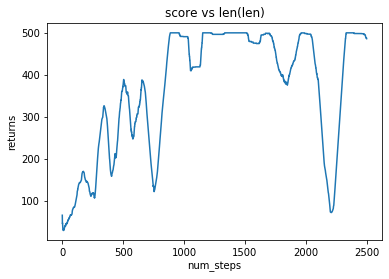

In [5]:
import matplotlib.pyplot as plt

x2=range(0,len(score_history))
#plt.plot(x2,score_history)
plt.plot(x2,rolling_average(score_history, window_size=100))
plt.title('score vs len(len)')
plt.xlabel('num_steps')
plt.ylabel('returns')
